# **LIP READING**

**OBJECTIVE:** the project aims to develop a deep learning-based lipreading system capable of accurately transcribing spoken language from visual cues captured in lip movements

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hari025kk","key":"bd3ebde0664f5eea51a3d05720d0acb5"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rishisrdy/lipreading

 99% 401M/404M [00:07<00:00, 43.2MB/s]
100% 404M/404M [00:07<00:00, 57.6MB/s]


In [ ]:
!unzip '/content/lipreading.zip'

Archive:  /content/lipreading.zip
  inflating: data/alignments/s1/bbaf2n.align  
  inflating: data/alignments/s1/bbaf3s.align  
  inflating: data/alignments/s1/bbaf4p.align  
  inflating: data/alignments/s1/bbaf5a.align  
  inflating: data/alignments/s1/bbal6n.align  
  inflating: data/alignments/s1/bbal7s.align  
  inflating: data/alignments/s1/bbal8p.align  
  inflating: data/alignments/s1/bbal9a.align  
  inflating: data/alignments/s1/bbas1s.align  
  inflating: data/alignments/s1/bbas2p.align  
  inflating: data/alignments/s1/bbas3a.align  
  inflating: data/alignments/s1/bbaszn.align  
  inflating: data/alignments/s1/bbaz4n.align  
  inflating: data/alignments/s1/bbaz5s.align  
  inflating: data/alignments/s1/bbaz6p.align  
  inflating: data/alignments/s1/bbaz7a.align  
  inflating: data/alignments/s1/bbbf6n.align  
  inflating: data/alignments/s1/bbbf7s.align  
  inflating: data/alignments/s1/bbbf8p.align  
  inflating: data/alignments/s1/bbbf9a.align  
  inflating: data/alignmen

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [ ]:
path="/content/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

In [ ]:
def get_vocab():
    vocab=[]
    directory="/content/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab

In [ ]:
vocab=np.unique(get_vocab())

In [ ]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


In [ ]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()



    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [ ]:
path="/content/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [ ]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/content/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/content/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)

    return frames,alignments

In [ ]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path='/content/data/s1/bbaf2n.mpg'
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

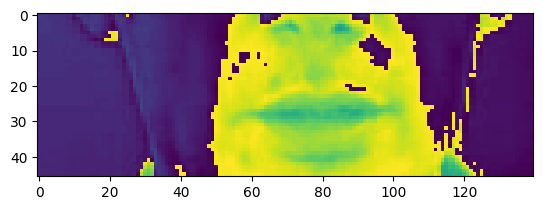

In [ ]:
plt.imshow(frames[15])

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(250)
test = data.skip(250)

In [ ]:
frames, alighnments = data.as_numpy_iterator().next()

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next();val[0]

array([[[[[ 1.4917026 ],
          [ 1.4917026 ],
          [ 1.367394  ],
          ...,
          [ 0.        ],
          [ 0.04143618],
          [ 0.04143618]],

         [[ 1.4917026 ],
          [ 1.4917026 ],
          [ 1.367394  ],
          ...,
          [ 0.        ],
          [ 0.04143618],
          [ 0.04143618]],

         [[ 1.367394  ],
          [ 1.367394  ],
          [ 1.367394  ],
          ...,
          [10.566227  ],
          [10.566227  ],
          [10.566227  ]],

         ...,

         [[ 0.9530322 ],
          [ 0.9530322 ],
          [ 0.9530322 ],
          ...,
          [10.31761   ],
          [10.31761   ],
          [10.31761   ]],

         [[ 0.9530322 ],
          [ 0.9530322 ],
          [ 0.9530322 ],
          ...,
          [10.31761   ],
          [10.31761   ],
          [10.31761   ]],

         [[ 0.9530322 ],
          [ 0.9530322 ],
          [ 0.9530322 ],
          ...,
          [10.31761   ],
          [10.31761   ],
          

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
model.fit(train,validation_data=test,epochs=5,callbacks=[checkpoint_callback,schedule_callback,example_callback])

Epoch 1/5
1/1 [==============================] - 2s 2s/step
Original: binblueatfthreesoon
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placebluebypfiveagain
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
250/250 [==============================] - 656s 3s/step - loss: 89.3514 - val_loss: 74.4481 - lr: 1.0000e-04
Epoch 2/5
1/1 [==============================] - 0s 214ms/step
Original: laygreeninfzerono
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredatjzerono
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
250/250 [==============================] - 513s 2s/step - loss: 74.7939 - val_loss: 68.9220 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 0s 214ms/ste

In [ ]:
model.save('lip_reading.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#!pip install keras-nightly

In [ ]:

test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 234ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'placehiteinjfiveagain'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'setredbybfivesoon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lao'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lao'>]